# Surf's Up
Performing Climate Analysis for the climate in Hawaii and also providing an api to share that with others.

## Climate Analysis
This notebook will read the climate data from the database and perform the analysis on that data. The following two notebooks need to be run before running this code to ensure we have the data in the database
1. data_engineering.ipynb
2. database_engineering.ipynb 

The SQLite database is availabe in the following file in the Resources folder:
* hawaii.sqlite

In [152]:
# python dependencies
import pandas as pd
import numpy as np
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import Column, Float, Integer, String, Date
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import ForeignKey

# Plotting dependencies
import matplotlib
from matplotlib import style
style.use("seaborn")
import matplotlib.pyplot as plt

In [153]:
# Create the database engine to get our data from
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
conn = engine.connect()

# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)

#inspect the tables
inspector = inspect(engine)

In [154]:
inspector.get_table_names()

['measurements', 'stations']

In [155]:
stations_result = conn.execute("SELECT * FROM stations LIMIT 5").fetchall()
stations_result

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [156]:
measurements_result = conn.execute("SELECT * FROM measurements order by date desc LIMIT 5").fetchall()
measurements_result


[(2685, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7318, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (10915, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (18103, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2684, 'USC00519397', '2017-08-22', 0.0, 82.0)]

### Precipitation Analysis
We will take a look at the last 12 months of precipitation data.

In [157]:
# Define our base object
Base = declarative_base()

# Define our data object classes
class Station(Base):
    __tablename__ = 'stations'
    id = Column(Integer, primary_key=True)
    station_id = Column(String(255))
    station_name = Column(String(255))
    latitude = Column(Float(3.5))
    longitude = Column(Float(3.5))
    elevation = Column(Float(3.1))

class Measurement(Base):
    __tablename__ = "measurements"
    id = Column(Integer, primary_key=True)
    station_id = Column(String(255), ForeignKey("stations.station_id"), nullable=False)
    date = Column(String(255))
    precipitation = Column(Float(1.2))
    temperature = Column(Float(3.2))
    

In [158]:
# Get the session object to run queries
session = Session(engine)

# Get the date a year ago
year_ago = dt.date.today() - dt.timedelta(days=365)

# query for the precipitation data in the past year
result = session.query(Measurement.date, Measurement.precipitation).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date.desc()).all()

In [159]:
# Create a dataframe from the result
precipitation_df = pd.DataFrame(result)
precipitation_df.head()

,date,precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


In [160]:
# Set the date column as index
precipitation_df.set_index('date', inplace=True)

In [161]:
precipitation_df["precipitation"].min()

0.0

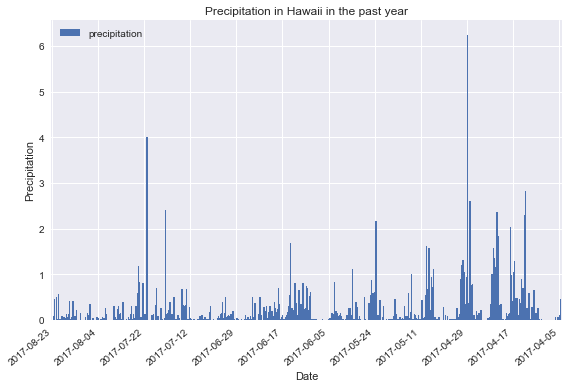

In [162]:
# calculate the values for the x-ticks
l = len(precipitation_df)
tick_locations = np.arange(0,l,int(l/11))
tick_labels = [precipitation_df.index[i] for i in tick_locations]

# Plot the data
precipitation_df.plot.bar(width=2)
plt.title("Precipitation in Hawaii in the past year")
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.xticks(tick_locations, tick_labels, rotation="40", ha="right")
plt.tight_layout()
plt.show()

### Precipitation Analysis Summary

In [165]:
precipitation_df.describe()

,precipitation
count,741.000000
mean,0.173252
std,0.436185
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,6.250000


### Station Analysis

#### Get the total number of stations.



In [166]:
# Total number of stations
result = session.query(func.count(Station.station_id)).all()
list(np.ravel(result))[0]

9

#### Get the most active station / Which station has the highest number of observations?

In [167]:
# define the function to use
station_count = func.count(Measurement.station_id)

result = session.query(Measurement.station_id, Station.station_name, station_count).\
        filter(Station.station_id == Measurement.station_id).\
        group_by(Measurement.station_id).order_by(station_count.desc()).first()

highest_obs_station = result[0]

df = pd.DataFrame([result], columns=["station_id", "station_name", "observation count"])
df

,station_id,station_name,observation count
0,USC00519281,"WAIHEE 837.5, HI US",2772


#### Get the stations and observation counts in descending order

In [168]:
result = session.query(Measurement.station_id, Station.station_name, station_count).\
        filter(Station.station_id == Measurement.station_id).\
        group_by(Measurement.station_id).order_by(station_count.desc()).all()

df = pd.DataFrame(result, columns=["station_id", "station_name", "observation count"])
df

,station_id,station_name,observation count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


In [169]:
query_string = "select m.station_id, s.station_name, count(m.station_id) AS station_count \
                from measurements m, stations s \
                where s.station_id=m.station_id \
                group by m.station_id \
                order by station_count desc"
conn.execute(query_string).fetchall()

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

#### Get the last 12 months of temperature observation data (tobs).

In [170]:
result = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
last_date = result[0]
prev_year_date = dt.datetime.strptime(last_date, '%Y-%m-%d').date() - dt.timedelta(days=365)
print(last_date)
print(prev_year_date)

2017-08-23
2016-08-23


In [171]:
result = session.query(Measurement.station_id, Measurement.date, Measurement.temperature).\
    filter(Measurement.date > prev_year_date).\
    order_by(Measurement.date.desc()).all()
result
df = pd.DataFrame(result, columns=["station_id", "date", "temperature"])
df.head(10)

,station_id,date,temperature
0,USC00519397,2017-08-23,81.0
1,USC00514830,2017-08-23,82.0
2,USC00519523,2017-08-23,82.0
3,USC00516128,2017-08-23,76.0
4,USC00519397,2017-08-22,82.0
5,USC00519523,2017-08-22,82.0
6,USC00516128,2017-08-22,76.0
7,USC00519397,2017-08-21,81.0
8,USC00514830,2017-08-21,79.0
9,USC00516128,2017-08-21,76.0


#### Filter by the station with the highest number of observations.

In [172]:
# Get the station id with the higest count from the last query using the data frame
count_df = df.groupby("station_id").count()
count_df.sort_values("date", ascending=False, inplace=True)
top_station = count_df.index[0]
top_station

'USC00519397'

In [173]:
result = session.query(Measurement.station_id, Measurement.date, Measurement.temperature).\
    filter(Measurement.date > prev_year_date).\
    filter(Measurement.station_id == top_station).\
    order_by(Measurement.date.desc()).all()
result
df = pd.DataFrame(result, columns=["station_id", "date", "temperature"])
df.head(10)

,station_id,date,temperature
0,USC00519397,2017-08-23,81.0
1,USC00519397,2017-08-22,82.0
2,USC00519397,2017-08-21,81.0
3,USC00519397,2017-08-20,81.0
4,USC00519397,2017-08-19,79.0
5,USC00519397,2017-08-18,80.0
6,USC00519397,2017-08-15,78.0
7,USC00519397,2017-08-14,79.0
8,USC00519397,2017-08-13,81.0
9,USC00519397,2017-08-12,80.0


#### Plot the results as a histogram with bins=12.

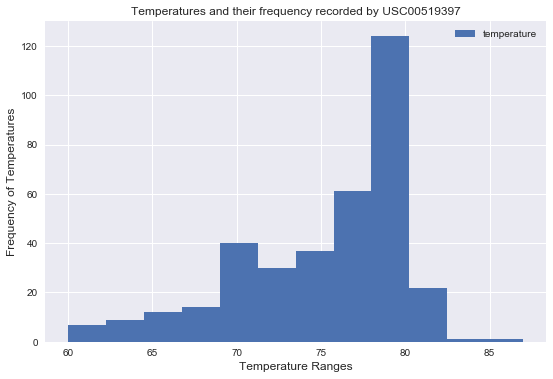

In [174]:
df.plot.hist("temperature", 12)
plt.ylabel("Frequency of Temperatures", size=12)
plt.xlabel("Temperature Ranges", size=12)
plt.title("Temperatures and their frequency recorded by {}".format(top_station), size=12)
plt.show()

### Temperature Analysis
Assuming we are planning a trip for the following dates:

Start Date - 05/17/2018

End Date - 05/25/2018

We will find the expected min, max and avg temperatures for our trip using the data for the same dates for the previous year i.e. (04/10/2017 - 05/25/2017)

We wil then plot the min, avg, and max temperature from our previous query as a bar chart with the average temperature as the bar height and the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [175]:
# Create date objects to store the trip start and end dates
trip_start = dt.date(2018,5,17)
trip_end = dt.date(2018, 5, 25)

In [176]:
# This function accepts a start date and end date and returns the min, max and avg temperatures
# for those dates.

def calc_temps(start, end) :
    avg_temp=0
    min_temp = 0
    max_temp=0
    
    result = session.query(Measurement.date, Measurement.temperature).\
        filter(Measurement.date > start).\
        filter(Measurement.date < end).\
        order_by(Measurement.date.desc()).all()
    df = pd.DataFrame(result, columns=["date", "temperature"])
    avg_temp = df["temperature"].mean()
    min_temp = df["temperature"].min()
    max_temp = df["temperature"].max()
    
    return(avg_temp, min_temp, max_temp)

In [177]:
t_avg, t_min, t_max = calc_temps(trip_start-dt.timedelta(days=365), trip_end-dt.timedelta(days=365))

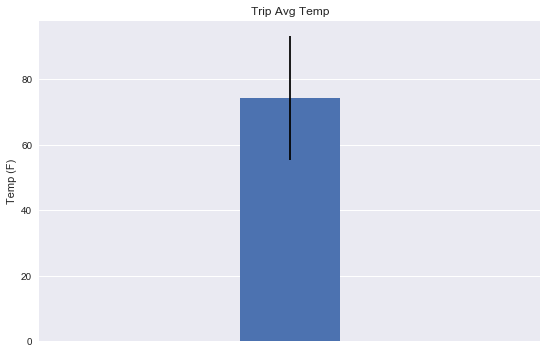

In [178]:
plt.bar([1], [t_avg], yerr=t_max-t_min, width=0.4)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(0,2)
plt.xticks([],[])
plt.show()

### Rainfall per weather Station
We will now find the rainfall recorded by each weather station for the previous year's dates that match our planned trip dates for this year. Our trip dates are:

Start Date - 05/17/2018

End Date - 05/25/2018



In [179]:
# This function gets the min, max and avg rainfall for each station recorded between the
# given start and end dates and returns a dataframe with the results
def calc_rainfall(start, end) :
    avg_rainfall=0
    min_rainfall = 0
    max_rainfall=0
    
    result = session.query(Station.station_id, func.min(Measurement.precipitation), func.max(Measurement.precipitation), func.avg(Measurement.precipitation)).\
        filter(Measurement.station_id == Station.station_id).\
        filter(Measurement.date > start).\
        filter(Measurement.date < end).\
        group_by(Station.station_id).all()
    df = pd.DataFrame(result, columns=["station", "min rainfall", "max rainfall", "average rainfall"])
    
    return(df)

In [180]:
rainfall_df = calc_rainfall(trip_start-dt.timedelta(days=365), trip_end-dt.timedelta(days=365))
rainfall_df

,station,min rainfall,max rainfall,average rainfall
0,USC00513117,0.00,0.58,0.101429
1,USC00514830,0.01,0.16,0.078000
2,USC00516128,0.00,2.17,0.582000
3,USC00519281,0.01,0.30,0.084286
4,USC00519397,0.00,0.13,0.031429
5,USC00519523,0.00,0.61,0.214000


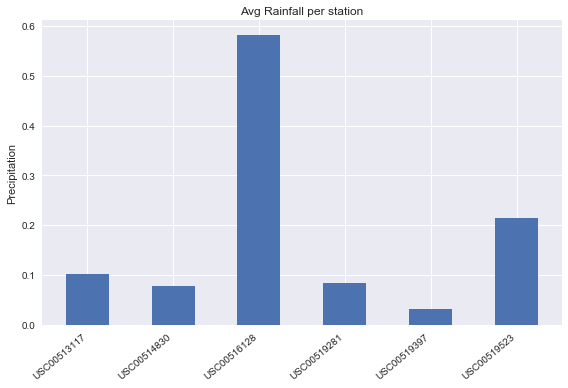

In [181]:
# Plot the average rainfall for all stations above
x_values = np.arange(1,len(rainfall_df)+1)

plt.bar(x_values, rainfall_df["average rainfall"], width=0.5)

plt.title("Avg Rainfall per station")
plt.ylabel("Precipitation")
plt.xticks(x_values,rainfall_df["station"], rotation="40", ha="right")
plt.tight_layout()
plt.show()

### Dialy Normals  Temperatures

Get the daily normals which are the averages for min, avg, and max temperatures. Then we will plot an area plot for the daily normals.

In [182]:
# Running a test query to get the min, max and avg temperatures recorded for a specific test day & month
conn.execute("select date, max(temperature), min(temperature), avg(temperature) \
            from measurements where date like '%-04-01' \
            group by date order by date").fetchall()

[('2010-04-01', 74.0, 69.0, 72.14285714285714),
 ('2011-04-01', 76.0, 67.0, 72.55555555555556),
 ('2012-04-01', 75.0, 71.0, 73.5),
 ('2013-04-01', 68.0, 61.0, 64.5),
 ('2014-04-01', 76.0, 69.0, 72.5),
 ('2015-04-01', 78.0, 69.0, 73.5),
 ('2016-04-01', 77.0, 68.0, 72.71428571428571),
 ('2017-04-01', 80.0, 69.0, 75.5)]

In [183]:
# This function will return the normalized min, max and avg values of temperatures for a
# given day of month extracted from the date passed in as a parameter.
def get_daily_normals(d):
    month_day = dt.date.strftime(d, '%m-%d')
    
    # Get the normals i.e. average min, average max and average avg of the above result
    query_str = "select avg(min_t), avg(max_t), avg(avg_t) \
                from (\
                    select date, min(temperature) min_t, \
                    max(temperature) max_t, avg(temperature) avg_t \
                    from measurements \
                    where date like '%-{}' \
                    group by date order by date)".format(month_day)

    result = conn.execute(query_str).fetchall()
    return np.ravel(result)

In [184]:
# Get the start and end dates for the data we want to analyze
start = trip_start-dt.timedelta(days=365)
end = trip_end-dt.timedelta(days=365)

In [185]:
# Initialize variables
delta = end-start
trip_dates = []
n_min = []
n_max = []
n_avg = []

# for all the days from start to end, get the normals and append to the respective arrays
for i in range(delta.days + 1):
    curr_date = start + dt.timedelta(days=i)
    normals = get_daily_normals(curr_date)
    
    trip_dates.append(dt.date.strftime(curr_date, '%m-%d'))
    n_min.append(normals[0])
    n_max.append(normals[1])
    n_avg.append(normals[2])
    
# Create a data frame from the daily normals values
normals_df = pd.DataFrame({"date": trip_dates, 
                           "min temp": n_min, 
                           "max temp": n_max, 
                           "avg temp": n_avg})


In [186]:
# Set the date as the index
normals_df.set_index("date", drop=True, inplace=True)
normals_df

,avg temp,max temp,min temp
date,,,
05-17,74.429315,77.750,70.125
05-18,74.062054,78.375,70.125
05-19,73.526042,77.500,68.625
05-20,73.877232,77.875,69.625
05-21,73.183333,77.125,68.500
05-22,74.415030,77.750,69.250
05-23,74.894792,79.000,70.500
05-24,74.091270,77.000,70.875
05-25,74.188740,77.375,70.125


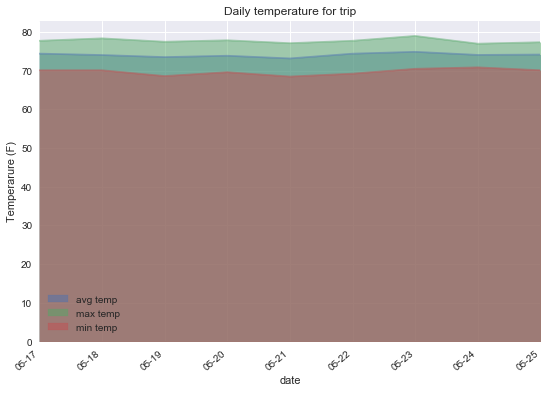

In [187]:
# Plot the daily normals using an area plot
normals_df.plot.area(stacked=False)
plt.ylabel("Temperarure (F)")
plt.title("Daily temperature for trip")
plt.xticks(rotation="40", ha="right")
plt.show()